In [ ]:
!pip install vtk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import vtk
from tqdm import tqdm

def fit_1d_gmm_pytorch(
    data,
    n_components=3,
    max_iter=50,
    tol=1e-6,
    device="cuda"
):
    """
    Fit a 1D GMM with `n_components` on `data` (a 1D numpy array) using EM.
    Returns (weights, means, stds), each of size n_components.
    """
    data = torch.tensor(data, dtype=torch.float32, device=device)
    N = data.shape[0]

    # Initialization: uniform weights, random means near data mean, and stds based on data std.
    torch.manual_seed(123)
    weights = (torch.ones(n_components, device=device) / n_components)
    means = torch.randn(n_components, device=device) * data.std() + data.mean()
    stds = (torch.ones(n_components, device=device) * data.std())

    prev_log_likelihood = -np.inf

    for iteration in range(max_iter):
        # E-step: Compute responsibilities for each component
        data_expanded = data.unsqueeze(1)  # shape (N,1)
        log_probs = -0.5 * np.log(2.0 * np.pi) - torch.log(stds) - 0.5 * ((data_expanded - means)**2 / (stds**2)) #shape(N,3)
        log_probs += torch.log(weights)#(N,3)

        # Normalize using log-sum-exp trick for numerical stability
        max_log = torch.max(log_probs, dim=1, keepdim=True)[0] #(N,1)
        log_probs_normalized = log_probs - max_log#(N,3)
        resp_unnormalized = torch.exp(log_probs_normalized)#(N,3)
        resp_denom = torch.sum(resp_unnormalized, dim=1, keepdim=True)#(N,1)
        responsibilities = resp_unnormalized / resp_denom#(N,3)

        # M-step: Update parameters based on responsibilities
        Nk = torch.sum(responsibilities, dim=0)#(1,3)
        weights = Nk / N#(1,3)
        means = torch.sum(responsibilities * data_expanded, dim=0) / Nk #(1,3)
        var = torch.sum(responsibilities * (data_expanded - means)**2, dim=0) / Nk #(1,3)
        stds = torch.sqrt(var) #(1,3)
        stds = torch.clamp(stds, min=1e-8) #(!,3)

        # Convergence check using log-likelihood
        log_likelihood = torch.sum(torch.log(torch.sum(torch.exp(log_probs_normalized), dim=1)) + max_log.squeeze())
        if torch.abs(log_likelihood - prev_log_likelihood) < tol:
            break
        prev_log_likelihood = log_likelihood

    # Return parameters as numpy arrays
    return weights.detach().cpu().numpy(), means.detach().cpu().numpy(), stds.detach().cpu().numpy()


In [ ]:
# Specify your input and output file names
input_filename = "/content/Teardrop_Gaussian.vti"
output_filename = "my_gmm.vti"

# Read the input .vti file using VTK
reader = vtk.vtkXMLImageDataReader()
reader.SetFileName(input_filename)
reader.Update()
image_data = reader.GetOutput()  # vtkImageData

dims = image_data.GetDimensions()  # e.g., (64, 64, 64)
num_points = dims[0] * dims[1] * dims[2]

# Retrieve the "Average" and "StandardDeviation" arrays from PointData
pd = image_data.GetPointData()
mean_array_vtk = pd.GetArray("Average")
std_array_vtk = pd.GetArray("Standard_Deviation")

if mean_array_vtk is None or std_array_vtk is None:
    raise ValueError("Could not find 'Average' or 'Standard_Deviation' in input .vti")

# Prepare output arrays for the 9 GMM parameters: 3 means, 3 std devs, 3 mixing coefficients.
def create_vtk_array(name):
    arr = vtk.vtkFloatArray()
    arr.SetName(name)
    arr.SetNumberOfComponents(1)
    arr.SetNumberOfTuples(num_points)
    return arr

gmm_mean0_vtk = create_vtk_array("GMM_Mean0")
gmm_mean1_vtk = create_vtk_array("GMM_Mean1")
gmm_mean2_vtk = create_vtk_array("GMM_Mean2")
gmm_std0_vtk  = create_vtk_array("GMM_Std0")
gmm_std1_vtk  = create_vtk_array("GMM_Std1")
gmm_std2_vtk  = create_vtk_array("GMM_Std2")
gmm_w0_vtk    = create_vtk_array("GMM_Weight0")
gmm_w1_vtk    = create_vtk_array("GMM_Weight1")
gmm_w2_vtk    = create_vtk_array("GMM_Weight2")


In [ ]:
# Set parameters for sample generation and scaling
scale_factor = 2.0      # Multiply the standard deviation by this factor.
n_samples_per_point = 500

# Loop over each grid point in the volume.
for pt_id in tqdm(range(num_points)):
    mu = mean_array_vtk.GetValue(pt_id)
    stdv = std_array_vtk.GetValue(pt_id)

    # Scale up the standard deviation
    scaled_std = scale_factor * stdv

    # Generate 500 samples from N(mu, (scaled_std)^2)
    samples = np.random.normal(loc=mu, scale=scaled_std, size=n_samples_per_point)

    # Fit a 3-component 1D GMM using the EM algorithm (implemented with PyTorch)
    weights, means, stds = fit_1d_gmm_pytorch(samples, n_components=3, max_iter=50)

    # Optional: Sort components by mean to get consistent ordering
    order = np.argsort(means)
    weights = weights[order]
    means = means[order]
    stds = stds[order]

    # Store the fitted parameters in the respective VTK arrays
    gmm_mean0_vtk.SetValue(pt_id, means[0])
    gmm_mean1_vtk.SetValue(pt_id, means[1])
    gmm_mean2_vtk.SetValue(pt_id, means[2])

    gmm_std0_vtk.SetValue(pt_id, stds[0])
    gmm_std1_vtk.SetValue(pt_id, stds[1])
    gmm_std2_vtk.SetValue(pt_id, stds[2])

    gmm_w0_vtk.SetValue(pt_id, weights[0])
    gmm_w1_vtk.SetValue(pt_id, weights[1])
    gmm_w2_vtk.SetValue(pt_id, weights[2])


100%|██████████| 262144/262144 [1:56:34<00:00, 37.48it/s]


In [ ]:
# Add the 9 new arrays to the PointData of the image
pd.AddArray(gmm_mean0_vtk)
pd.AddArray(gmm_mean1_vtk)
pd.AddArray(gmm_mean2_vtk)
pd.AddArray(gmm_std0_vtk)
pd.AddArray(gmm_std1_vtk)
pd.AddArray(gmm_std2_vtk)
pd.AddArray(gmm_w0_vtk)
pd.AddArray(gmm_w1_vtk)
pd.AddArray(gmm_w2_vtk)

pd.RemoveArray("Average")
pd.RemoveArray("Standard_Deviation")


# Write the updated vtkImageData to a new .vti file
writer = vtk.vtkXMLImageDataWriter()
writer.SetFileName(output_filename)
writer.SetInputData(image_data)
writer.Write()

print(f"Done. Output written to: {output_filename}")


Done. Output written to: my_gmm.vti


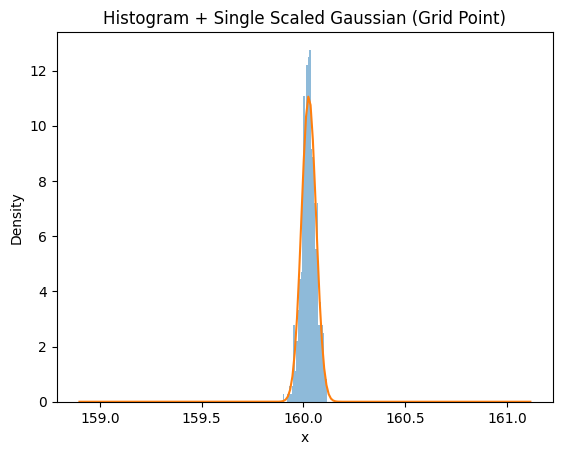

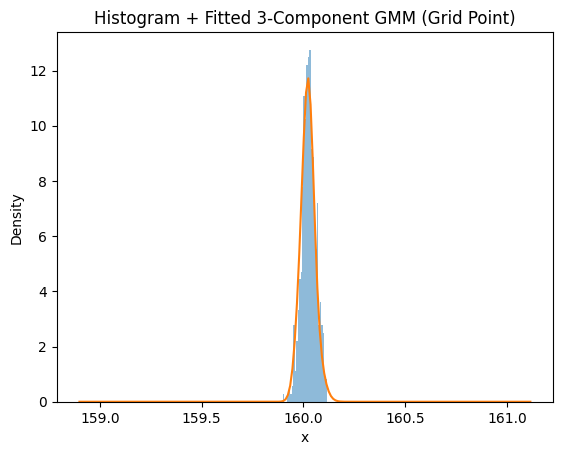

In [ ]:
# Choose a grid point to visualize (e.g., the center of the volume)
center_i = (dims[0] + 4) // 2
center_j = dims[1] // 2
center_k = dims[2] // 2
center_pt_id = (center_k * dims[1] + center_j) * dims[0] + center_i

# Retrieve original parameters at the selected grid point
orig_mu = mean_array_vtk.GetValue(center_pt_id)
orig_std = std_array_vtk.GetValue(center_pt_id)
scaled_std = scale_factor * orig_std

# Generate samples for visualization
samples_center = np.random.normal(loc=orig_mu, scale=scaled_std, size=n_samples_per_point)

# Retrieve the fitted GMM parameters from the VTK arrays
mix = [
    gmm_w0_vtk.GetValue(center_pt_id),
    gmm_w1_vtk.GetValue(center_pt_id),
    gmm_w2_vtk.GetValue(center_pt_id)
]
comps_mean = [
    gmm_mean0_vtk.GetValue(center_pt_id),
    gmm_mean1_vtk.GetValue(center_pt_id),
    gmm_mean2_vtk.GetValue(center_pt_id)
]
comps_std = [
    gmm_std0_vtk.GetValue(center_pt_id),
    gmm_std1_vtk.GetValue(center_pt_id),
    gmm_std2_vtk.GetValue(center_pt_id)
]

# ----- Visualization 1: Single Scaled Gaussian -----
plt.figure()
plt.hist(samples_center, bins=30, density=True, alpha=0.5)

x_values = np.linspace(samples_center.min()-1, samples_center.max()+1, 200)
single_gaussian_pdf = (
    1.0 / (np.sqrt(2.0 * np.pi) * scaled_std) *
    np.exp(-(x_values - orig_mu)**2 / (2.0 * scaled_std**2))
)
plt.plot(x_values, single_gaussian_pdf)
plt.title("Histogram + Single Scaled Gaussian (Grid Point)")
plt.xlabel("x")
plt.ylabel("Density")
plt.show()

# ----- Visualization 2: Fitted 3-Component GMM -----
plt.figure()
plt.hist(samples_center, bins=30, density=True, alpha=0.5)

# Compute and plot the mixture PDF from the fitted GMM components
gmm_pdf = np.zeros_like(x_values)
for w, m, s in zip(mix, comps_mean, comps_std):
    component_pdf = (
        1.0 / (np.sqrt(2.0 * np.pi) * s) *
        np.exp(-(x_values - m)**2 / (2.0 * s**2))
    )
    gmm_pdf += w * component_pdf

plt.plot(x_values, gmm_pdf)
plt.title("Histogram + Fitted 3-Component GMM (Grid Point)")
plt.xlabel("x")
plt.ylabel("Density")
plt.show()


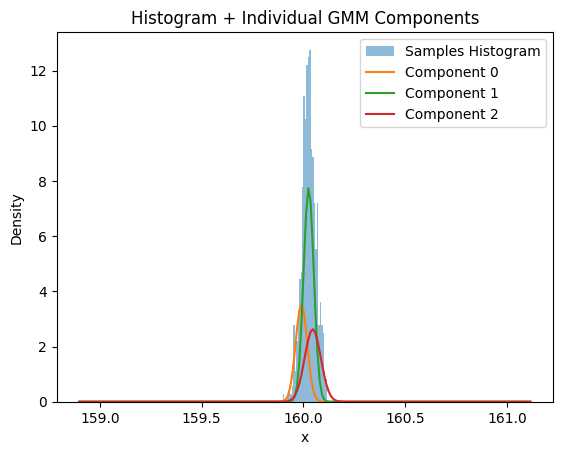

In [ ]:
# Visualization: Plot each individual GMM component with different colors.
plt.figure()

# Plot histogram of the samples (density normalized)
plt.hist(samples_center, bins=30, density=True, alpha=0.5, label="Samples Histogram")

# Generate x values for plotting the PDFs
x_values = np.linspace(samples_center.min()-1, samples_center.max()+1, 200)

# Plot each Gaussian component separately
for i, (w, m, s) in enumerate(zip(mix, comps_mean, comps_std)):
    component_pdf = w * (1.0 / (np.sqrt(2.0 * np.pi) * s)) * np.exp(-((x_values - m)**2) / (2.0 * s**2))
    plt.plot(x_values, component_pdf, label=f"Component {i}")

plt.title("Histogram + Individual GMM Components")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:
# import vtk
# import numpy as np
# import matplotlib.pyplot as plt

# # Read the output VTI file (which contains only the GMM parameters)
# input_filename = "/kaggle/input/vortex-gassian/vortex_uncert.vti"
# reader = vtk.vtkXMLImageDataReader()
# reader.SetFileName(input_filename)
# reader.Update()
# image_data = reader.GetOutput()

# dims = image_data.GetDimensions()  # (64, 64, 64)
# num_points = dims[0] * dims[1] * dims[2]

# # Get the GMM parameter arrays from the PointData
# pd = image_data.GetPointData()
# gmm_mean0_vtk = pd.GetArray("GMM_Mean0")
# gmm_mean1_vtk = pd.GetArray("GMM_Mean1")
# gmm_mean2_vtk = pd.GetArray("GMM_Mean2")
# gmm_std0_vtk  = pd.GetArray("GMM_Std0")
# gmm_std1_vtk  = pd.GetArray("GMM_Std1")
# gmm_std2_vtk  = pd.GetArray("GMM_Std2")
# gmm_w0_vtk    = pd.GetArray("GMM_Weight0")
# gmm_w1_vtk    = pd.GetArray("GMM_Weight1")
# gmm_w2_vtk    = pd.GetArray("GMM_Weight2")

# # Specify the grid point indices
# assigned_i = 40
# assigned_j = 32
# assigned_k = 32

# # Compute the flat point index from the 3D indices
# point_id = (assigned_k * dims[1] + assigned_j) * dims[0] + assigned_i

# # Retrieve the fitted GMM parameters for that grid point
# mix = [
#     gmm_w0_vtk.GetValue(point_id),
#     gmm_w1_vtk.GetValue(point_id),
#     gmm_w2_vtk.GetValue(point_id)
# ]
# comps_mean = [
#     gmm_mean0_vtk.GetValue(point_id),
#     gmm_mean1_vtk.GetValue(point_id),
#     gmm_mean2_vtk.GetValue(point_id)
# ]
# comps_std = [
#     gmm_std0_vtk.GetValue(point_id),
#     gmm_std1_vtk.GetValue(point_id),
#     gmm_std2_vtk.GetValue(point_id)
# ]

# print("GMM Parameters at grid point (i, j, k) = ({}, {}, {}):".format(assigned_i, assigned_j, assigned_k))
# print("Mixing coefficients:", mix)
# print("Component means:", comps_mean)
# print("Component std deviations:", comps_std)

# # Generate synthetic samples from the fitted GMM for visualization
# n_samples = 500
# samples = []
# cum_weights = np.cumsum(mix)
# for _ in range(n_samples):
#     r = np.random.rand()
#     if r < cum_weights[0]:
#         comp = 0
#     elif r < cum_weights[1]:
#         comp = 1
#     else:
#         comp = 2
#     sample = np.random.normal(loc=comps_mean[comp], scale=comps_std[comp])
#     samples.append(sample)
# samples = np.array(samples)

# # Create x-values for plotting the PDFs
# x_values = np.linspace(samples.min()-1, samples.max()+1, 200)

# # ----- Visualization 1: Overall GMM PDF -----
# plt.figure()
# plt.hist(samples, bins=30, density=True, alpha=0.5, label="GMM Samples")
# gmm_pdf = np.zeros_like(x_values)
# for w, m, s in zip(mix, comps_mean, comps_std):
#     component_pdf = w * (1.0 / (np.sqrt(2.0 * np.pi) * s)) * np.exp(-((x_values - m)**2) / (2.0 * s**2))
#     gmm_pdf += component_pdf
# plt.plot(x_values, gmm_pdf, label="Overall GMM PDF", linewidth=2)
# plt.title("Histogram + Overall GMM PDF (Grid Point)")
# plt.xlabel("x")
# plt.ylabel("Density")
# plt.legend()
# plt.show()

# # ----- Visualization 2: Individual GMM Components -----
# plt.figure()
# plt.hist(samples, bins=30, density=True, alpha=0.5, label="GMM Samples")
# colors = ['r', 'g', 'b']
# for i, (w, m, s, color) in enumerate(zip(mix, comps_mean, comps_std, colors)):
#     component_pdf = w * (1.0 / (np.sqrt(2.0 * np.pi) * s)) * np.exp(-((x_values - m)**2) / (2.0 * s**2))
#     plt.plot(x_values, component_pdf, color=color, label=f"Component {i}")
# plt.title("Histogram + Individual GMM Components (Grid Point)")
# plt.xlabel("x")
# plt.ylabel("Density")
# plt.legend()
# plt.show()


In [ ]:
# import vtk

# # Specify the input and output file names
# input_filename = "/kaggle/input/fit-gmm3/gmm3.vti"
# output_filename = "gmm3.vti"

# # Read the input .vti file using vtkXMLImageDataReader
# reader = vtk.vtkXMLImageDataReader()
# reader.SetFileName(input_filename)
# reader.Update()
# image_data = reader.GetOutput()

# # Get the PointData from the vtkImageData
# pd = image_data.GetPointData()

# # Remove unwanted arrays from the PointData
# pd.RemoveArray("Average")
# pd.RemoveArray("Standard_Deviation")

# # Write the updated vtkImageData to a new .vti file with only the desired arrays
# writer = vtk.vtkXMLImageDataWriter()
# writer.SetFileName(output_filename)
# writer.SetInputData(image_data)
# writer.Write()

# print(f"Output written to: {output_filename} with only the 9 GMM arrays.")
